CI pipeline create by classical editor (graphical UI)

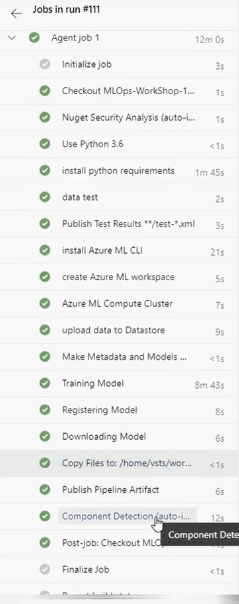
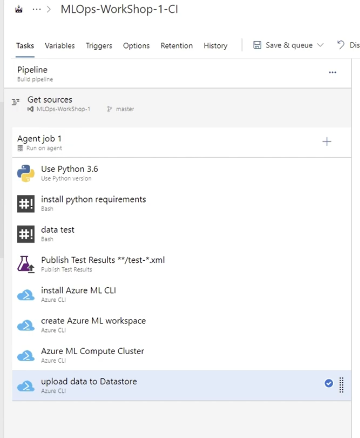

tasks:<br>
- Use Python 3.6
- install python requirements
- unit tests
- Publish Test Results **/test-*.xml
- install Azure ML CLI
- create Azure ML workspace
- Create Azure ML Compute Cluster
- upload data to Datastore
- Create Metadata and create directory for Models
- Train the ML Model
- Registering Model
- Downloading Model
- Copy Files (artifacts you built in dev pipeline) to: $(Build.ArtifactStagingDirectory)
- Publish Pipeline Artifact


it first installs azure ml cli and then it uses azure ml cli for with a bash inline command
- create Azure ML workspace
- Azure ML Compute Cluster
- upload data to Datastore
- etc ...

gpt output to create the CI pipeline with pipeline as code (pac):<br>

**note**: scripts are different from videos.


```yaml
trigger:
- main

pool:
  vmImage: 'ubuntu-latest'

steps:

# Use Python 3.6
- task: UsePythonVersion@0
  inputs:
    versionSpec: '3.6'

# Install Python requirements
- script: |
    python -m pip install --upgrade pip
    pip install -r requirements.txt
  displayName: 'Install Python Requirements'

# Run data tests
- script: |
    pytest tests/ --junitxml=test-results/results.xml
  displayName: 'Run Data Tests'

# Publish Test Results
- task: PublishTestResults@2
  inputs:
    testResultsFiles: '**/test-*.xml'
    testRunTitle: 'Publish Test Results'

# Install Azure ML CLI
- script: |
    curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash
    az extension add -n azure-cli-ml
  displayName: 'Install Azure ML CLI'

# Create Azure ML Workspace
- script: |
    az login --service-principal -u $(azureServicePrincipalUsername) -p $(azureServicePrincipalPassword) --tenant $(azureTenant)
    az ml workspace create --name $(workspaceName) --resource-group $(resourceGroupName) --location $(location)
  displayName: 'Create Azure ML Workspace'

# Create Azure ML Compute Cluster
- script: |
    az ml compute create --name $(computeName) --size Standard_DS11_v2 --min-instances 0 --max-instances 4 --workspace-name $(workspaceName) --resource-group $(resourceGroupName)
  displayName: 'Create Azure ML Compute Cluster'

# Upload data to Datastore
- script: |
    az ml data upload --path ./data --name dataset_name --datastore-name workspaceblobstore --workspace-name $(workspaceName) --resource-group $(resourceGroupName)
  displayName: 'Upload Data to Datastore'


# Make Metadata and Models directory
- script: |
    mkdir -p metadata
    mkdir -p models
  displayName: 'Make Metadata and Models directory'

# Training Model
- script: |
    az ml job create --file train-job.yml --workspace-name $(workspaceName) --resource-group $(resourceGroupName)
  displayName: 'Training Model'

# Registering Model
- script: |
    az ml model register --name my-model --path ./models --workspace-name $(workspaceName) --resource-group $(resourceGroupName)
  displayName: 'Registering Model'

# Downloading Model
- script: |
    az ml model download --name my-model --version 1 --download-path ./models --workspace-name $(workspaceName) --resource-group $(resourceGroupName)
  displayName: 'Downloading Model'

# Copy Files to Artifact Staging Directory
- task: CopyFiles@2
  inputs:
    SourceFolder: '$(Build.SourceDirectory)'
    Contents: '**/models/* **/deployment/* **/test/integration/* **/package_requirement/*'
    TargetFolder: '$(Build.ArtifactStagingDirectory)'
  displayName: 'Copy Files to: $(Build.ArtifactStagingDirectory)'

# Publish Pipeline Artifact
- task: PublishPipelineArtifact@1
  inputs:
    targetPath: '$(Build.ArtifactStagingDirectory)'
    artifactName: 'landing'
    publishLocation: 'pipeline'
  displayName: 'Publish Pipeline Artifact'

```


### Q. what is tasks in cicd pipeline?
`task` is a builtin/pre-defined plugin or module to do a commonly needed action. <br>
so you don't have to write shell scripts for everything. Azure DevOps comes with many built-in tasks, and you can also create custom ones.

```yaml
- task: TaskName@Version
  inputs:
    input1: value1
    input2: value2
  displayName: 'Optional Friendly Name'
```

- task: – Specifies the task name and version (@1, @2, etc.).
- inputs: – Key-value settings that configure what the task does.
- displayName: – Optional label to describe what the task does (shown in the pipeline UI).


### Q. what are artifacts?

artifacts are `outputs of your pipeline` <br>
Examples: compiled code, trained model, metadata, package dependencies, tests, configuration files, test results, etc.)

### Q. what is artifact staging in CI pipeline?

artifact staging is the process of collecting and organizing the the artifacts of your CI pipeline (`outputs of your pipeline`) into a central location known as the staging directory. These outputs, called artifacts, are then published and can be used by subsequent pipeline stages (especially in release pipelines or deployments).

### Q. what is published artifact in CI pipeline?

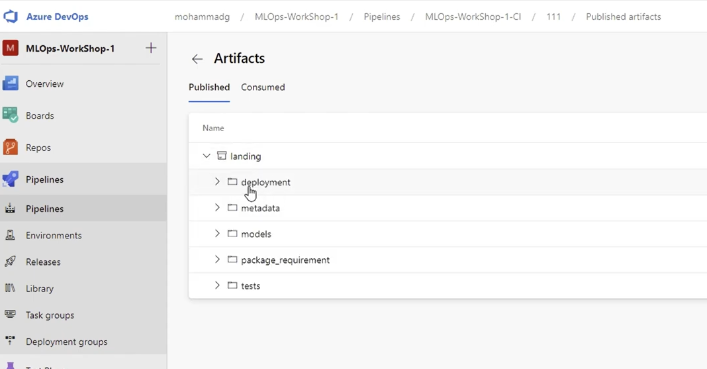

Your Published Artifacts include folders like:

- deployment
- metadata
- models
- package_requirement
- tests

you create these outputs (aka artifacts) during CI pipeline,<br>
the these were staged the artifacts (i.e., copy the output files into `ArtifactStagingDirectory`) during the CI pipeline, <br>
 and then published using the PublishBuildArtifacts task.

## Q. what happens in `PublishPipelineArtifact`?
This task packages all files found in $(Build.ArtifactStagingDirectory) into an artifact called landing, and publishes it to the pipeline (<u>upload the artifacts to the internal storage of pipeline</u>), making it accessible for other stages/jobs or even other pipelines.

Q. where is the location that pipeline uploads the artifacts?<br>
Azure DevOps Pipeline internal storage


```yaml
# Publish Pipeline Artifact
- task: PublishPipelineArtifact@1
  inputs:
    targetPath: '$(Build.ArtifactStagingDirectory)'
    artifactName: 'landing'
    publishLocation: 'pipeline'
  displayName: 'Publish Pipeline Artifact'

```

🔄 Steps Behind the Scenes: `PublishPipelineArtifact`

---

##### 1. File Collection
✅ **What happens:**  
Azure DevOps scans the folder you specify in `targetPath` and gathers all files and subfolders.

🧠 **Why:**  
To package everything you want to share between pipeline stages or download later.

---

##### 2. Packaging (if needed)
✅ **What happens:**  
Files are optionally compressed or bundled for efficient transfer.

🧠 **Why:**  
Makes uploading and downloading faster and less error-prone.

---

##### 3. Upload to Artifact Storage
✅ **What happens:**  
Files are securely uploaded to Azure DevOps' built-in storage, tied to the pipeline run.

🧠 **Why:**  
So they’re safely stored, versioned, and available later.

---

##### 4. Metadata Generation
✅ **What happens:**  
Azure records file names, sizes, timestamps, and links them to the pipeline run and artifact name.

🧠 **Why:**  
To support file browsing and downloading from the DevOps UI.

---

##### 5. Artifact Available in UI
✅ **What happens:**  
The artifact appears in the **Artifacts** section of the pipeline run in the Azure DevOps portal.

🧠 **Why:**  
You or your team can inspect, download, or reuse the files easily.

---

##### 6. Reuse in Later Stages (Optional)
✅ **What happens:**  
Other pipeline stages (or jobs) can **download the artifact** using `DownloadPipelineArtifact@2`.

🧠 **Why:**  
Supports multi-stage pipelines, like build → test → deploy workflows.
